## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Utility functions

In [3]:
def normalize(dataframe):
    for column_name in dataframe.columns:
        x_min = dataframe[column_name].min()
        x_max = dataframe[column_name].max()
        dataframe[column_name] = dataframe[column_name].map(lambda x: (x-x_min)/(x_max-x_min))
    return dataframe

## Reading Dataset

In [4]:
df = pd.read_csv('students performace.csv')

df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


## Data Preprocessing

In [5]:
operation_df = df.iloc[:,-3:]
operation_df = normalize(operation_df)
operation_df

,math score,reading score,writing score
0,0.72,0.662651,0.711111
1,0.69,0.879518,0.866667
2,0.90,0.939759,0.922222
3,0.47,0.481928,0.377778
4,0.76,0.734940,0.722222
...,...,...,...
995,0.88,0.987952,0.944444
996,0.62,0.457831,0.500000
997,0.59,0.650602,0.611111
998,0.68,0.734940,0.744444


## Translation of Origin

New origin is the averages of all the datapoints along respective axes.
e.g sum of x-axis plot of all observations / number of observations = x of new origin

In [6]:
new_x_origin = operation_df['math score'].mean()
new_y_origin = operation_df['reading score'].mean()
new_z_origin = operation_df['writing score'].mean()

print(f'({new_x_origin},{new_y_origin},{new_z_origin}) is the new origin')

(0.660890000000001,0.628542168674699,0.645044444444444) is the new origin


## Calculating maximum sum of squared distances

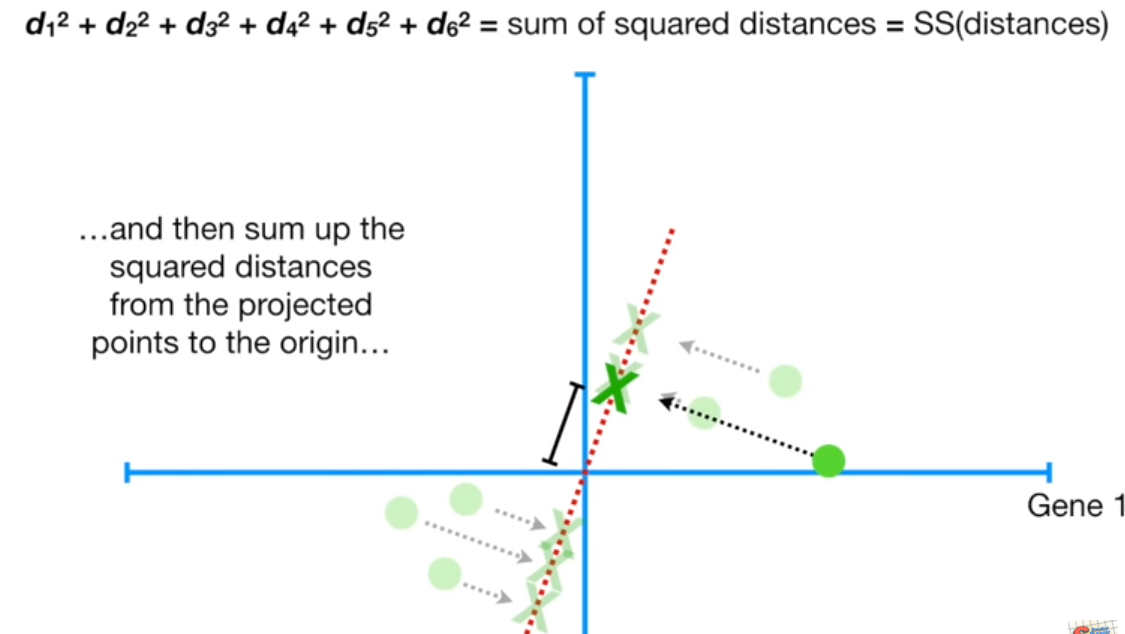

Here what I have tried is that create random planes along the axis and then find the one which has maximum distance from the translated origin. 

$$ Ax+By+Cz=D $$

I tried randomizing the $A,B,C,D$ and repeating it to find the max distance from origin. 

# Finding Principal Components

1. Find the plane passing through translated origin(accurate to 2 decimal places,otherwise no convergence)
2. Then for that plane,find all the squared distances using Pythagoras Theorem
3. Repeat first 2 steps for desired number of random planes
4. On completion, find the maximum distance and the plane correspoding to it. 
5. Repeat steps 1 to 4 for the other principal components(with extra condition of perpendicular)

## Utility Functions 

In [7]:
def get_parameters():
    A = 0.0
    B = 0.0
    C = 0.0
    D = 0.0
    try:
        while A == 0.0 or A == -0.0:
            A = round(np.random.uniform(-1, 1),2)
        while B == 0.0 or B == -0.0:
            B = round(np.random.uniform(-1, 1),2)
        while C == 0.0 or C == -0.0:
            C = round(np.random.uniform(-1, 1),2)
        while D == 0.0 or D == -0.0:
            D = round(np.random.uniform(-1, 1),2)
        
        distance = round(abs(A*new_x_origin+B*new_y_origin+C*new_z_origin-D)
                                         /(A**2+B**2+C**2)**(0.5),3)
        
        return A,B,C,D,distance
    except:
        get_parameters()

In [243]:
number_of_planes = 10

principal_components = []

num_of_principal_components = len(operation_df.columns)


for pc in range(num_of_principal_components):
    plane_count = 0
    plane_stats = [] #Two Dimensional Matrix where each row -> A,B,C,D,Sum of Distance
    #step 3
    while plane_count < number_of_planes:
        #step 1
        A,B,C,D,distance_from_origin = get_parameters()
        distance_check_count = 0
        crosses_origin = distance_from_origin==0
        #step 5
        perpendicular_to_first = True
        perpendicular_to_second = True

        while(not crosses_origin or not perpendicular_to_first or not perpendicular_to_second):
            A,B,C,D,distance_from_origin = get_parameters()
            #update flags
            crosses_origin = distance_from_origin==0
            if pc != 0:
                Ax,By,Cz = principal_components[0][:-1]
                perpendicular_to_first = (round(Ax*A+By*B+Cz*C,1) == 0)
            if pc == 2:
                Ax,By,Cz = principal_components[1][:-1]
                perpendicular_to_second = (round(Ax*A+By*B+Cz*C,1) == 0)
            distance_check_count += 1
        print(f'Plane {plane_count} found after {distance_check_count} iterations')
        actual_distance = abs((A*new_x_origin+B*new_y_origin+C*new_z_origin-D))/(A**2+B**2+C**2)**(0.5)
        print(f'The actual distance is: {actual_distance}')

        #step 2
        total_sum_squared = 0
        for index,record in operation_df.iterrows():
            x,y,z = np.asarray(record)
            distance_from_plane = abs((A*x+B*y+C*z-D))/ (A**2+B**2+C**2)**(0.5)
            distance_from_new_origin_squared = ((x-new_x_origin)**2+(y-new_y_origin)**2+(z-new_z_origin)**2)
            #using pythagoras
            squared_distance_from_origin = distance_from_new_origin_squared - distance_from_plane**2
            total_sum_squared += squared_distance_from_origin
        plane_stats.append([A,B,C,D,total_sum_squared])
        plane_count += 1

    #step 4
    max_index = 0
    for i in range(len(plane_stats)):
        if plane_stats[i][-1] > plane_stats[max_index][-1]:
            max_index = i
    principal_components.append(plane_stats[max_index][:-1])

Plane 0 found after 634 iterations
The actual distance is: 0.0003645442985613982
Plane 1 found after 1390 iterations
The actual distance is: 0.00016468014858710963
Plane 2 found after 675 iterations
The actual distance is: 0.0003860714944330324
Plane 3 found after 1386 iterations
The actual distance is: 0.0002423721533249898
Plane 4 found after 4769 iterations
The actual distance is: 0.0004919817620487355
Plane 5 found after 1230 iterations
The actual distance is: 0.00028975649714244934
Plane 6 found after 2365 iterations
The actual distance is: 3.075125721641528e-05
Plane 7 found after 2706 iterations
The actual distance is: 0.0001905543829021133
Plane 8 found after 69 iterations
The actual distance is: 0.000396307547775757
Plane 9 found after 3801 iterations
The actual distance is: 7.669617395056729e-05
Plane 0 found after 91170 iterations
The actual distance is: 0.00014667495528739255
Plane 1 found after 258466 iterations
The actual distance is: 0.00013373831697672628
Plane 2 found 

In [244]:
print(principal_components)

[[-0.05, 0.94, -0.85, 0.01], [0.66, -0.09, -0.17, 0.27], [0.05, 0.25, 0.31, 0.39]]


## Finding variations

$$ Variation(PC1) = \frac{SS(distance from PC1)}{(n-1)} $$

In [247]:
n = len(operation_df)
print(n)
variations = []
for pc in principal_components:    
    A,B,C,D = pc
    for index,record in operation_df.iterrows():
        x,y,z = np.asarray(record)
        distance_from_plane = abs((A*x+B*y+C*z-D))/ (A**2+B**2+C**2)**(0.5)
        distance_from_new_origin_squared = ((x-new_x_origin)**2+(y-new_y_origin)**2+(z-new_z_origin)**2)
        #using pythagoras
        squared_distance_from_origin = distance_from_new_origin_squared - distance_from_plane**2
        total_sum_squared += squared_distance_from_origin
    variations.append(total_sum_squared/(n-1))
print(variations)

1000
[0.09343092303848022, 0.16581046886178433, 0.1842694195027796]
